# Part II: Model disagreement

Looking into cases that the simple model got right and the complex model got wrong.

Defined as:
- lgbm24max < 0.4
- preds_24max > 0.55
- diff24max > 0.2

Should be about 32 of them

Check out pat services and lv of care trajectories.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data

Load in the data

In [2]:
# predicted labels
results_dir = "/home/eulalio/BMI212/2019_data/ProjectTriage/"
datadir = "/home/eulalio/BMI212/2019_data/"

label_24max_0_errors_f = "label_24max_0_errors.csv"
label_24max_1_errors_f = "label_24max_1_errors.csv"
adt_file = datadir + "traige_cohort_2019_adt.csv"
results_24hr_max_file = datadir + "results_gbw.csv"
csn_file = datadir + "cohort_2019_csns.csv"
all_labels_file = datadir + "triage_cohort_final_with_labels.csv"


lab0_errors = pd.read_csv(results_dir + label_24max_0_errors_f)
lab1_errors = pd.read_csv(results_dir + label_24max_1_errors_f)
adt = pd.read_csv(adt_file)
results_24hr_max = pd.read_csv(results_24hr_max_file)
csns = pd.read_csv(csn_file)
all_labels = pd.read_csv(all_labels_file)

Find the cases that models disagreed.

In [3]:
results_24hr_max.pat_enc_csn_id_coded.nunique()

10096

In [4]:
results_24hr_max.head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,admit_label,has_admit_label,first_label,first_label_time_since_admit,label_12hr_recent,label_24hr_recent,acute_to_critical_label,critical_to_acute_label,label_max24,lgbm24,lgbm24max,preds_24,preds_24max,preds1_24,preds1_24max
0,JCe3a0de,131260430594,33212811,2019-01-01 09:19:00+00:00,0.0,1,0,0,0,0,0,0,0,0.067691,0.126939,0.045002,0.076868,0.044143,0.058368
1,JCde6879,131260494741,33234258,2019-01-01 23:44:00+00:00,0.0,1,0,0,0,0,0,0,0,0.195685,0.225225,0.067069,0.094981,0.233573,0.378279
2,JCe039f4,131260628973,33283549,2019-01-01 08:14:00+00:00,0.0,1,0,0,0,0,0,0,0,0.285779,0.258251,0.108184,0.129025,0.181669,0.311396
3,JCe0ef14,131260654663,33293419,2019-01-05 22:54:00+00:00,1.0,1,1,0,1,1,0,0,1,0.374375,0.594023,0.129532,0.212817,0.125657,0.206693
4,JCe8c709,131260660815,33295470,2019-01-01 05:06:00+00:00,0.0,1,0,0,0,0,0,0,0,0.344107,0.340510,0.351736,0.297359,0.273046,0.332407


In [5]:
results_24hr_max['diff24max'] = abs(results_24hr_max.lgbm24max - results_24hr_max.preds_24max)

In [6]:
disagree = results_24hr_max[(results_24hr_max.lgbm24max < 0.4) &
                      (results_24hr_max.preds_24max > 0.55) &
                    (results_24hr_max.diff24max > 0.2) &
                        (results_24hr_max.label_max24 == 1)
                      ]

disagree.shape

(32, 20)

In [7]:
lab1 = results_24hr_max[results_24hr_max.label_max24 == 1]

In [8]:
# mark the cns that are errors
lab1['label1_simple'] = lab1.pat_enc_csn_id_coded.isin(disagree.pat_enc_csn_id_coded)
lab1['other'] = ~lab1.pat_enc_csn_id_coded.isin(disagree.pat_enc_csn_id_coded)

lab1['label1_complex'] = (lab1.other) & (lab1.lgbm24 > 0.6) & (lab1.preds_24max < 0.45)
lab1['label1_both'] = (lab1.other) & (lab1.lgbm24 > 0.6) & (lab1.preds_24max > 0.45)
lab1['label1_neither'] = (lab1.other) & (~lab1.label1_complex) & (~lab1.label1_both)


# get one column to label the error type for each csn
wide = lab1.melt(id_vars = 'pat_enc_csn_id_coded',
                             value_vars = ['label1_simple', 'label1_complex',
                                          'label1_both', 'label1_neither'],
                            var_name = 'error_type',
                            value_name = 'error_val',
                            )
wide = wide.drop_duplicates()

error_type = wide[wide.error_val == True]

# add it back to the original df
# results_24hr_max = results_24hr_max.merge(wide_true, how='left')

# results_24hr_max.head()
error_type.head()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,pat_enc_csn_id_coded,error_type,error_val
97,131262443217,label1_simple,True
120,131262723057,label1_simple,True
191,131263490910,label1_simple,True
241,131263878860,label1_simple,True
246,131263979960,label1_simple,True


In [9]:
error_type.pat_enc_csn_id_coded.nunique()

1520

In [10]:
error_type.error_type.value_counts()

label1_neither    1314
label1_both        140
label1_complex      34
label1_simple       32
Name: error_type, dtype: int64

In [11]:
# add the admit time column from the prediction results csv to the adt csv
adt_admit = adt.merge(error_type, how='left')
adt_admit.head()

adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min', 'error_type', 'error_val'],
      dtype='object')

In [12]:
# filter down to our cohort
adt_admit = adt_admit[adt_admit.pat_enc_csn_id_coded.isin(error_type.pat_enc_csn_id_coded)]

# do we still have all of the CSNs? - YES
adt_admit.pat_enc_csn_id_coded.nunique()

1520

In [13]:
# mark the events with some labels that make things easier later
adt_admit = adt_admit.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'])

# **assumes dataframe is sorted by time

# mark whether previous entry had pat class Emergency Services
adt_admit['prev_emerg'] = adt_admit.pat_class.shift() == 'Emergency Services'
# mark whether current event has pat class Inpatient
adt_admit['curr_inpatient'] = adt_admit.pat_class == 'Inpatient'
# mark whether current event is continued csn as previous
adt_admit['continued'] = adt_admit.pat_enc_csn_id_coded.eq(
    adt_admit.pat_enc_csn_id_coded.shift())

# find our cases by taking the AND of these columns
cols = ['prev_emerg', 'curr_inpatient', 'continued']
adt_admit['first_ip'] = adt_admit[cols].all(axis=1)

adt_admit.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,seq_num_in_enc,seq_num_in_bed_min,error_type,error_val,prev_emerg,curr_inpatient,continued,first_ip
297698,JCe0ef14,131260654663,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-05 19:36:00 UTC,2019-01-05 19:36:00 UTC,1,1.0,label1_neither,True,False,False,False,False
297165,JCe0ef14,131260654663,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2019-01-05 21:50:00 UTC,2019-01-05 21:50:00 UTC,2,1.0,label1_neither,True,True,False,True,False
297558,JCe0ef14,131260654663,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2019-01-05 21:50:00 UTC,2019-01-05 21:50:00 UTC,3,1.0,label1_neither,True,True,False,True,False
25218,JCe0ef14,131260654663,Inpatient,Critical Care,Patient Update,Neurocritical Care,NaN,Ward,2019-01-05 22:54:00 UTC,2019-01-05 22:57:00 UTC,4,1.0,label1_neither,True,True,True,True,True
25395,JCe0ef14,131260654663,Inpatient,Critical Care,Patient Update,Neurocritical Care,NaN,Ward,2019-01-05 23:04:00 UTC,2019-01-05 23:04:00 UTC,5,1.0,label1_neither,True,False,True,True,False


# Look at first inpatient pat services

In [14]:
first_ips = adt_admit[adt_admit.first_ip == True]

first_ips.pat_enc_csn_id_coded.nunique()

1519

In [15]:
first_ips.head()

first_ips[first_ips.error_type == 'label1_simple']

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,seq_num_in_enc,seq_num_in_bed_min,error_type,error_val,prev_emerg,curr_inpatient,continued,first_ip
28038,JCce3941,131262443217,Inpatient,Critical Care,Patient Update,Cardiovascular ICU,NaN,Ward,2019-02-07 02:14:00 UTC,2019-02-07 02:40:00 UTC,6,1.0,label1_simple,True,True,True,True,True
248864,JCd136c5,131262723057,Inpatient,Critical Care,Patient Update,Emergency,NaN,Ward,2019-01-01 23:40:00 UTC,2019-01-01 23:40:00 UTC,2,1.0,label1_simple,True,True,True,True,True
361633,JCe0af20,131263490910,Inpatient,Critical Care,Patient Update,Emergency,NaN,Ward,2019-01-24 22:10:00 UTC,2019-01-24 22:10:00 UTC,2,1.0,label1_simple,True,True,True,True,True
252309,JC2a09257,131263878860,Inpatient,Critical Care,Patient Update,Emergency,NaN,Ward,2019-02-06 23:00:00 UTC,2019-02-06 23:00:00 UTC,4,1.0,label1_simple,True,True,True,True,True
556225,JCd9c01a,131263979960,Inpatient,Critical Care,Patient Update,Critical Care,NaN,Ward,2019-01-25 03:14:00 UTC,2019-01-25 03:18:00 UTC,4,1.0,label1_simple,True,True,True,True,True
687730,JC2a23de5,131264282674,Inpatient,Critical Care,Patient Update,ICU Trauma/GenSurg,NaN,Ward,2019-02-01 02:32:00 UTC,2019-02-01 02:34:00 UTC,6,1.0,label1_simple,True,True,True,True,True
550887,JC2a324d9,131264399411,Inpatient,Critical Care,Patient Update,Critical Care,NaN,Ward,2019-04-05 21:27:00 UTC,2019-04-05 21:35:00 UTC,2,1.0,label1_simple,True,True,True,True,True
245507,JCcfde34,131264533858,Inpatient,Critical Care,Patient Update,Emergency,NaN,Ward,2019-02-15 04:06:00 UTC,2019-02-15 04:06:00 UTC,6,1.0,label1_simple,True,True,True,True,True
161494,JCd08eaa,131265420999,Inpatient,Acute Care (Assessment or intervention q4-8),Patient Update,Medicine,NaN,Ward,2019-03-21 21:04:00 UTC,2019-03-21 21:05:00 UTC,4,1.0,label1_simple,True,True,True,True,True
36497,JCd80bfa,131265432012,Inpatient,Critical Care,Patient Update,Emergency Critical Care,NaN,Ward,2019-04-10 23:49:00 UTC,2019-04-10 23:51:00 UTC,4,1.0,label1_simple,True,True,True,True,True


In [16]:
# see a table
sorted_disagree = first_ips.groupby(['pat_service', 'error_type']).size().unstack(fill_value=0).sort_values('label1_simple', 
                                                                                          ascending=False)
sorted_disagree

error_type,label1_both,label1_complex,label1_neither,label1_simple
pat_service,,,,
Emergency,33,12,366,9
Cardiology,5,0,62,5
Critical Care,36,7,204,4
Emergency Critical Care,1,0,35,3
Emergency Medicine,33,9,221,3
General Medicine (University),3,0,39,2
Trauma,10,2,103,2
Cardiovascular ICU,1,0,16,2
Medicine,3,0,27,1


In [17]:
sorted_disagree['sum'] = sorted_disagree.sum(axis=1)

sorted_disagree = sorted_disagree.loc[:,"label1_both":"label1_simple"].div(sorted_disagree['sum'], axis=0) * 100

sorted_disagree = sorted_disagree.sort_values('label1_simple', ascending=False)

sorted_disagree

error_type,label1_both,label1_complex,label1_neither,label1_simple
pat_service,,,,
Cardiovascular ICU,5.263158,0.000000,84.210526,10.526316
Emergency Critical Care,2.564103,0.000000,89.743590,7.692308
Cardiology,6.944444,0.000000,86.111111,6.944444
General Medicine (University),6.818182,0.000000,88.636364,4.545455
Medicine,9.677419,0.000000,87.096774,3.225806
ICU Trauma/GenSurg,11.111111,2.222222,84.444444,2.222222
Emergency,7.857143,2.857143,87.142857,2.142857
Trauma,8.547009,1.709402,88.034188,1.709402
Critical Care,14.342629,2.788845,81.274900,1.593625


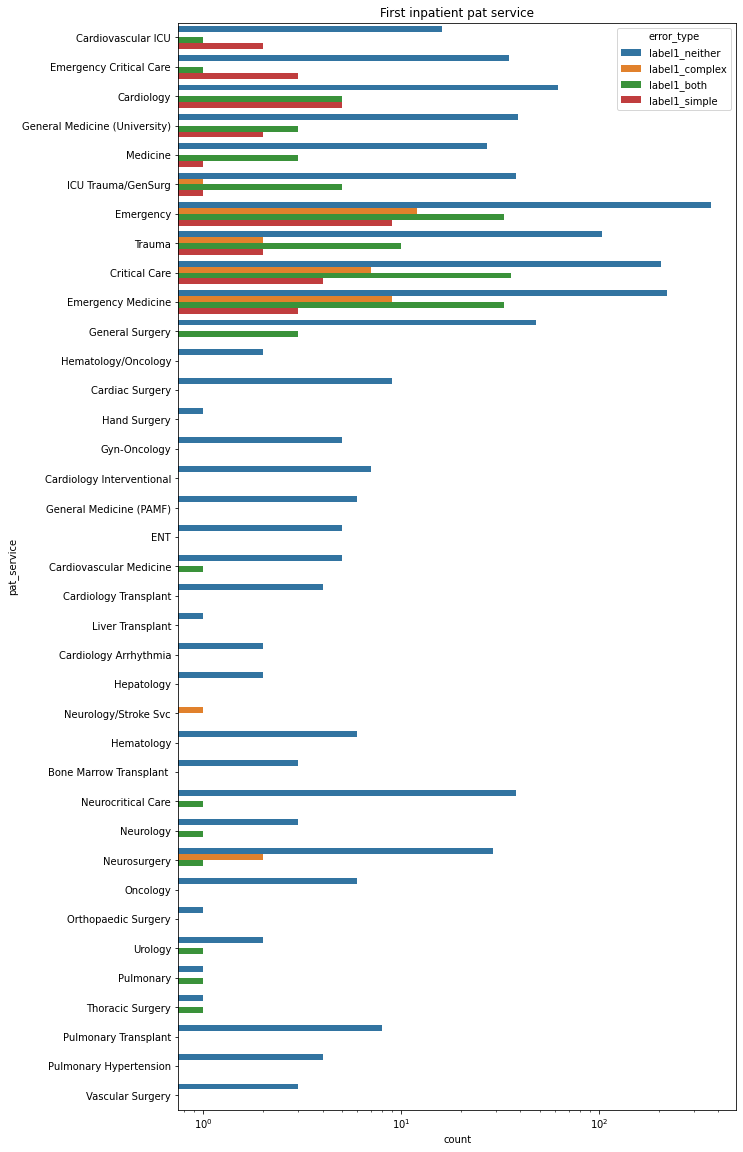

In [18]:
# plot them
plt.figure(figsize=(10,20))
p = sns.countplot(data=first_ips,
             y='pat_service',
              hue='error_type',
            order = list(sorted_disagree.index)
             )

p.set_xscale('log')
plt.title("First inpatient pat service")

plt.show()

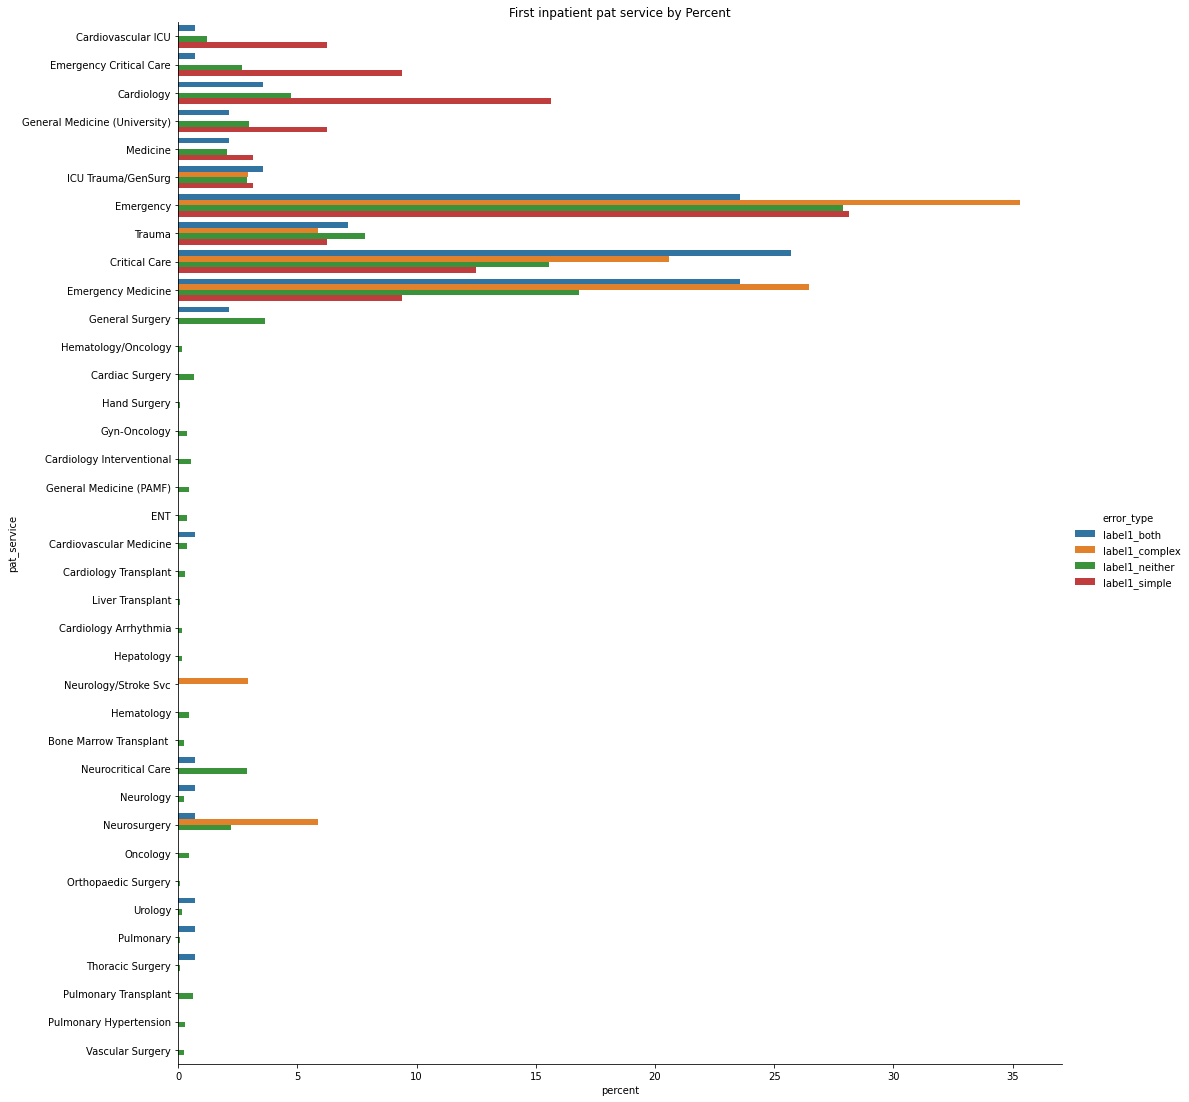

In [19]:
# plot percentages
df1 = first_ips.groupby('error_type')['pat_service'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

p = sns.catplot(y='pat_service',
               x='percent',
               hue='error_type',
               kind='bar',
               data=df1,
               height=15,
               order=list(sorted_disagree.index))
# p.fig.get_axes()[0].set_xscale('log')
plt.title("First inpatient pat service by Percent")

plt.show()

## Look at last Emergeny Services Pat Service

In [20]:
# mark the events with some labels that make things easier later

# **assumes dataframe is sorted by time

# mark whether next entry is inpatient
adt_admit['next_ip'] = adt_admit.pat_class.shift(-1) == 'Inpatient'
# mark whether current event has pat class Inpatient
adt_admit['curr_emerg'] = adt_admit.pat_class == 'Emergency Services'
# mark whether current event is continued csn as previous
adt_admit['not_continued'] = ~adt_admit.pat_enc_csn_id_coded.eq(
    adt_admit.pat_enc_csn_id_coded.shift(-1))

# find our cases by taking the AND of these columns
cols = ['next_ip', 'curr_emerg', 'continued']
adt_admit['last_emerg'] = adt_admit.curr_emerg & (adt_admit.next_ip | adt_admit.not_continued) 

adt_admit[['pat_enc_csn_id_coded', 'pat_class', 'last_emerg'] + cols].head(20)

,pat_enc_csn_id_coded,pat_class,last_emerg,next_ip,curr_emerg,continued
297698,131260654663,Emergency Services,False,False,True,False
297165,131260654663,Emergency Services,False,False,True,True
297558,131260654663,Emergency Services,True,True,True,True
25218,131260654663,Inpatient,False,True,False,True
25395,131260654663,Inpatient,False,True,False,True
25230,131260654663,Inpatient,False,True,False,True
25056,131260654663,Inpatient,False,True,False,True
25109,131260654663,Inpatient,False,True,False,True
25005,131260654663,Inpatient,False,True,False,True
25163,131260654663,Inpatient,False,True,False,True


In [21]:
last_emergs = adt_admit[adt_admit.last_emerg == True]

print(last_emergs.pat_enc_csn_id_coded.nunique())

last_emergs.head()

1519


,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,error_type,error_val,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg
297558,JCe0ef14,131260654663,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2019-01-05 21:50:00 UTC,2019-01-05 21:50:00 UTC,...,label1_neither,True,True,False,True,False,True,True,False,True
342320,JCd25448,131260687489,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2019-01-05 09:02:00 UTC,2019-01-05 09:02:00 UTC,...,label1_neither,True,True,False,True,False,True,True,False,True
249408,JCe7730f,131260730304,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-04 22:53:00 UTC,2019-01-04 22:53:00 UTC,...,label1_neither,True,False,False,False,False,True,True,False,True
286746,JCe81fb3,131260740716,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-07 01:16:00 UTC,2019-01-07 01:16:00 UTC,...,label1_neither,True,False,False,False,False,True,True,False,True
259630,JCd68a92,131260806868,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-04 17:15:00 UTC,2019-01-04 17:15:00 UTC,...,label1_neither,True,False,False,False,False,True,True,False,True


In [22]:
adt_admit.error_type.value_counts()

label1_neither    29403
label1_both        4000
label1_complex      889
label1_simple       648
Name: error_type, dtype: int64

In [23]:
last_emergs.error_type.value_counts()

label1_neither    1313
label1_both        140
label1_complex      34
label1_simple       32
Name: error_type, dtype: int64

In [24]:
# see a table
last_emergs.groupby(['pat_service', 'error_type']).size().unstack(fill_value=0).sort_values('label1_simple', 
                                                                                          ascending=False)

error_type,label1_both,label1_complex,label1_neither,label1_simple
pat_service,,,,
Emergency,70,21,783,20
Emergency Medicine,70,13,528,12
Cardiovascular Medicine,0,0,1,0
Trauma,0,0,1,0


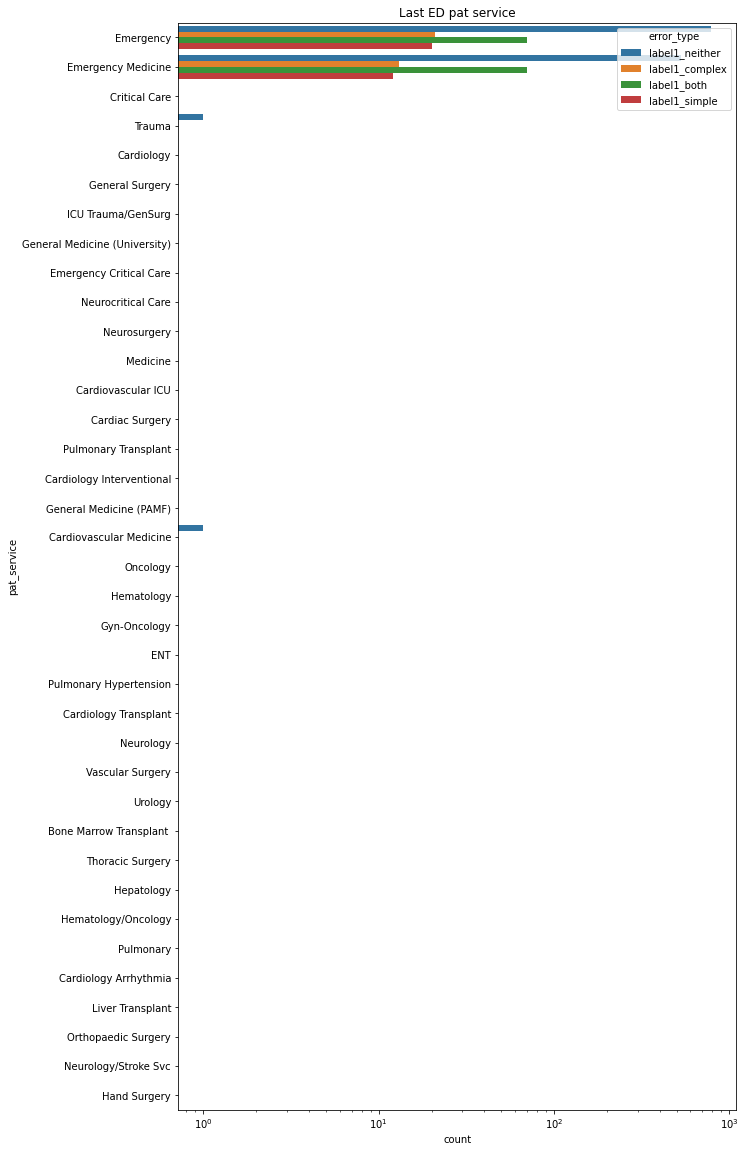

In [25]:
# plot them
plt.figure(figsize=(10,20))
p = sns.countplot(data=last_emergs,
             y='pat_service',
              hue='error_type',
            order = first_ips.pat_service.value_counts().index
             )

p.set_xscale('log')
plt.title("Last ED pat service")

plt.show()

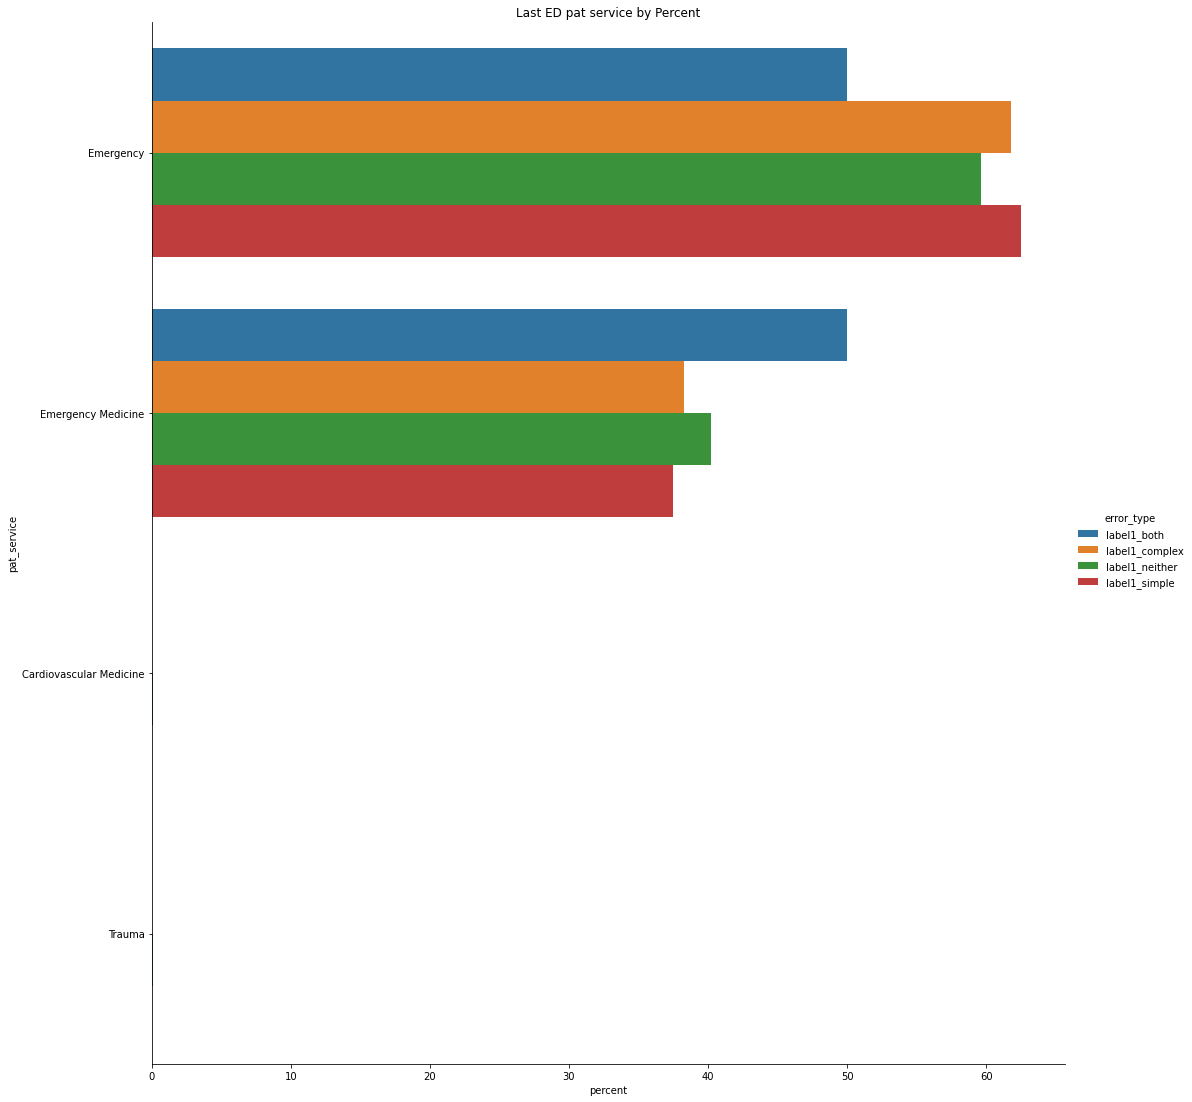

In [26]:
# plot percentages
df1 = last_emergs.groupby('error_type')['pat_service'].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()

p = sns.catplot(y='pat_service',
               x='percent',
               hue='error_type',
               kind='bar',
               data=df1,
               height=15)
# p.fig.get_axes()[0].set_xscale('log')
plt.title("Last ED pat service by Percent")

plt.show()

# Pat lv of care

Look at pat lv of care when patients are admitted

In [27]:
adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min', 'error_type', 'error_val',
       'prev_emerg', 'curr_inpatient', 'continued', 'first_ip', 'next_ip',
       'curr_emerg', 'not_continued', 'last_emerg'],
      dtype='object')

In [28]:
results_24hr_max.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded',
       'admit_time', 'admit_label', 'has_admit_label', 'first_label',
       'first_label_time_since_admit', 'label_12hr_recent',
       'label_24hr_recent', 'acute_to_critical_label',
       'critical_to_acute_label', 'label_max24', 'lgbm24', 'lgbm24max',
       'preds_24', 'preds_24max', 'preds1_24', 'preds1_24max', 'diff24max'],
      dtype='object')

In [29]:
# we only want inpatient events after the admission time

# add the admit time
adt_results = adt_admit.merge(all_labels[['pat_enc_csn_id_coded', 'admit_time']], how='left')
adt_results.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min', 'error_type', 'error_val',
       'prev_emerg', 'curr_inpatient', 'continued', 'first_ip', 'next_ip',
       'curr_emerg', 'not_continued', 'last_emerg', 'admit_time'],
      dtype='object')

In [30]:
# change admit time and effective time to datetime - these take a littl while to run!!

# change the effective time to datetime since read in from csv
adt_results.effective_time_jittered_utc = pd.to_datetime(adt_results.effective_time_jittered_utc)

# change admit time
adt_results.admit_time = pd.to_datetime(adt_results.admit_time)

In [31]:
# filter down to 24hrs after admit
adt_results['time_since_admit'] = adt_results.effective_time_jittered_utc - adt_results.admit_time

adt_results_24hr = adt_results[adt_results.time_since_admit < timedelta(hours=24)]

adt_results_24hr.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg,admit_time,time_since_admit
0,JCe0ef14,131260654663,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-05 19:36:00+00:00,2019-01-05 19:36:00 UTC,...,False,False,False,False,False,True,False,False,2019-01-05 22:54:00+00:00,-1 days +20:42:00
1,JCe0ef14,131260654663,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2019-01-05 21:50:00+00:00,2019-01-05 21:50:00 UTC,...,True,False,True,False,False,True,False,False,2019-01-05 22:54:00+00:00,-1 days +22:56:00
2,JCe0ef14,131260654663,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2019-01-05 21:50:00+00:00,2019-01-05 21:50:00 UTC,...,True,False,True,False,True,True,False,True,2019-01-05 22:54:00+00:00,-1 days +22:56:00
3,JCe0ef14,131260654663,Inpatient,Critical Care,Patient Update,Neurocritical Care,NaN,Ward,2019-01-05 22:54:00+00:00,2019-01-05 22:57:00 UTC,...,True,True,True,True,True,False,False,False,2019-01-05 22:54:00+00:00,0 days 00:00:00
4,JCe0ef14,131260654663,Inpatient,Critical Care,Patient Update,Neurocritical Care,NaN,Ward,2019-01-05 23:04:00+00:00,2019-01-05 23:04:00 UTC,...,False,True,True,False,True,False,False,False,2019-01-05 22:54:00+00:00,0 days 00:10:00


In [32]:
# filter to inpatient events after admit time
ip_events = adt_results_24hr[(adt_results_24hr.admit_time <= adt_results_24hr.effective_time_jittered_utc) &
                     (adt_results_24hr.pat_class == 'Inpatient')]

ip_events.pat_enc_csn_id_coded.nunique()

1520

In [33]:
# keep only change of lv of care status

# sort by sequence 
ip_events = ip_events.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'])

# keep only those that change
change_care = ip_events[~(ip_events.pat_lv_of_care.eq(ip_events.pat_lv_of_care.shift()) &
                         ip_events.pat_enc_csn_id_coded.eq(ip_events.pat_enc_csn_id_coded.shift()))]

change_care.pat_enc_csn_id_coded.nunique()

1520

In [34]:
change_care.size

57624

In [35]:
change_care[change_care.pat_enc_csn_id_coded.eq(change_care.shift().pat_enc_csn_id_coded)].head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,prev_emerg,curr_inpatient,continued,first_ip,next_ip,curr_emerg,not_continued,last_emerg,admit_time,time_since_admit
24,JCd25448,131260687489,Inpatient,Acute Care (Assessment or intervention q4-8),Patient Update,Trauma,NaN,Ward,2019-01-05 11:13:00+00:00,2019-01-05 11:13:00 UTC,...,False,True,True,False,True,False,False,False,2019-01-05 09:45:00+00:00,0 days 01:28:00
42,JCe7730f,131260730304,Inpatient,Acute Care (Assessment or intervention q4-8),Patient Update,Critical Care,NaN,Semi-Private,2019-01-05 19:06:00+00:00,2019-01-05 19:06:00 UTC,...,False,True,True,False,True,False,False,False,2019-01-05 03:09:00+00:00,0 days 15:57:00
43,JCe7730f,131260730304,Inpatient,IICU/Intermediate Care (Assessment or interven...,Patient Update,Critical Care,NaN,Semi-Private,2019-01-05 21:26:00+00:00,2019-01-05 21:26:00 UTC,...,False,True,True,False,True,False,False,False,2019-01-05 03:09:00+00:00,0 days 18:17:00
88,JCd68a92,131260806868,Inpatient,Critical Care,Patient Update,Cardiology Transplant,NaN,Private,2019-01-05 01:43:00+00:00,2019-01-05 01:43:00 UTC,...,False,True,True,False,True,False,False,False,2019-01-04 20:10:00+00:00,0 days 05:33:00
214,JCd56121,131261119075,Inpatient,Critical Care,Patient Update,Emergency,NaN,Ward,2019-01-11 23:39:00+00:00,2019-02-03 22:11:00 UTC,...,False,True,True,False,True,False,False,False,2019-01-11 23:03:00+00:00,0 days 00:36:00


In [36]:
trajectory = change_care[['pat_enc_csn_id_coded', 'pat_lv_of_care']].groupby('pat_enc_csn_id_coded').agg(
{'pat_lv_of_care' : lambda x: ' -> '.join([str(c) for c in x])}).reset_index().rename({'pat_lv_of_care': 'care_trajectory'}, axis=1)

In [37]:
# join to the change care df again
ip_traj = trajectory.merge(ip_events[['pat_enc_csn_id_coded', 'error_type']], how='left').drop_duplicates()

In [38]:
ip_traj.columns

Index(['pat_enc_csn_id_coded', 'care_trajectory', 'error_type'], dtype='object')

In [39]:
counts = ip_traj.groupby(['error_type', 'pat_enc_csn_id_coded']).care_trajectory.value_counts().groupby(['error_type', 'care_trajectory']).describe()

In [40]:
traj_count = ip_traj.groupby(['error_type']).agg(traj_count=pd.NamedAgg(column='care_trajectory', aggfunc='value_counts')).reset_index().sort_values(['error_type', 'traj_count'], ascending=False)

traj_count

,error_type,care_trajectory,traj_count
46,label1_simple,Critical Care,11
47,label1_simple,Critical Care -> Acute Care (Assessment or int...,10
48,label1_simple,Critical Care -> IICU/Intermediate Care (Asses...,5
49,label1_simple,Acute Care (Assessment or intervention q4-8) -...,1
50,label1_simple,Acute Care (Assessment or intervention q4-8) -...,1
51,label1_simple,Critical Care -> Acute Care (Assessment or int...,1
52,label1_simple,Critical Care -> IICU/Intermediate Care (Asses...,1
53,label1_simple,IICU/Intermediate Care (Assessment or interven...,1
54,label1_simple,IICU/Intermediate Care (Assessment or interven...,1
15,label1_neither,Critical Care,644


In [41]:
traj_count_sub = traj_count.groupby('error_type').head(10)

traj_count_sub.to_csv("/home/eulalio/BMI212/2019_data/cohort_2019_label1_errors_care_trajectories.csv",
                     sep="\t", index=False)

In [42]:
traj_count_sub

,error_type,care_trajectory,traj_count
46,label1_simple,Critical Care,11
47,label1_simple,Critical Care -> Acute Care (Assessment or int...,10
48,label1_simple,Critical Care -> IICU/Intermediate Care (Asses...,5
49,label1_simple,Acute Care (Assessment or intervention q4-8) -...,1
50,label1_simple,Acute Care (Assessment or intervention q4-8) -...,1
51,label1_simple,Critical Care -> Acute Care (Assessment or int...,1
52,label1_simple,Critical Care -> IICU/Intermediate Care (Asses...,1
53,label1_simple,IICU/Intermediate Care (Assessment or interven...,1
54,label1_simple,IICU/Intermediate Care (Assessment or interven...,1
15,label1_neither,Critical Care,644
